In [28]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import lifetimes as life
pd.set_option("display.max_columns", 100)
%matplotlib inline

Import, format sales_data and remove transactions that do not have email addresses (i.e. transactions that occured in stores).

In [29]:
sales_data = pd.read_csv("shopify_orders_export_20180207.csv", low_memory=False )
sales_data['Paid at'] = pd.to_datetime(sales_data['Paid at'])
sales_data['Fulfilled at'] = pd.to_datetime(sales_data['Fulfilled at'])
sales_data['Created at'] = pd.to_datetime(sales_data['Created at'])
sales_data = sales_data.drop(sales_data.columns.to_series()[-11:-1], axis=1)
sales_data_clean = sales_data[(sales_data['Financial Status'] == 'paid') & (sales_data['Email'].isnull() == False)]
# if I want to keep each transaction to one line only: add "(sales_data['Financial Status'].isnull() == False) &"

In [30]:
# Format the sales data into a layout accepted by Lifetime

sales_data_lifetimes_layout = sales_data_clean[['Paid at', 'Email', 'Subtotal']].reset_index()
sales_data_lifetimes_layout.drop(['index'], axis=1, inplace=True)
sales_data_lifetimes_layout= sales_data_lifetimes_layout[sales_data_lifetimes_layout['Paid at']> '2016-12-01']

# normalize the datetime to days only (all starting at 00:00:00)
# sales_data_lifetimes_layout['Paid at'] = sales_data_lifetimes_layout['Paid at'].dt.normalize()
sales_data_lifetimes_layout
# sales_data_lifetimes_layout.to_csv("transaction_history.csv")

,Paid at,Email,Subtotal
0,2018-02-08 03:59:00,gilly.glanville@me.com,290.0
1,2018-02-08 03:39:25,stephaniedata@yahoo.com,38.0
2,2018-02-08 00:42:57,hsmeaton@hotmail.com,48.0
3,2018-02-07 14:58:31,litepiggy@yahoo.com.sg,75.0
4,2018-02-07 13:45:51,alyssacmy@gmail.com,42.0
5,2018-02-07 13:02:33,jglyj82@gmail.com,82.0
6,2018-02-07 11:55:12,yeoslfiona@hotmail.com,217.0
7,2018-02-07 11:33:14,vinothini.112@gmail.com,34.0
8,2018-02-07 11:25:32,wailing_93@hotmail.com,84.0
9,2018-02-07 11:20:49,jesse.dytioco@gmail.com,170.0


In [60]:
sales_data_lifetimes_layout[sales_data_lifetimes_layout['Email'] == 'jovi.kau@gmail.com']

,Paid at,Email,Subtotal
279,2018-01-30 01:51:08,jovi.kau@gmail.com,91.0
1802,2017-12-04 11:24:22,jovi.kau@gmail.com,82.0
2899,2017-10-31 06:01:38,jovi.kau@gmail.com,117.0
4391,2017-09-10 14:44:11,jovi.kau@gmail.com,82.0
4971,2017-08-19 07:42:18,jovi.kau@gmail.com,89.0
5738,2017-07-23 06:23:35,jovi.kau@gmail.com,82.0
6866,2017-06-11 10:33:58,jovi.kau@gmail.com,82.0
7904,2017-04-23 05:38:48,jovi.kau@gmail.com,89.0
8497,2017-03-26 06:07:08,jovi.kau@gmail.com,48.0
8498,2017-03-26 06:06:16,jovi.kau@gmail.com,41.0


Now that we have formatted the sales data properly, we can now apply utility functions by `Lifetimes` to transform our  transactional data (one row per purchase) into a dataframe with the following:
### `frequency` 
represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. **It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.**

### `T`  (age)
represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

### `recency` 
represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

In [31]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = sales_data_lifetimes_layout.copy()
# transaction_data.tail(10)

summary = summary_data_from_transaction_data(transactions= sales_data_lifetimes_layout, 
                                             customer_id_col= 'Email', 
                                             datetime_col='Paid at',
                                             monetary_value_col='Subtotal',
                                             observation_period_end = None)
# print out for preview
# summary.to_excel("Freq Recency Monetary Value.xlsx")
summary.sort_values(by='monetary_value', ascending=False)

,frequency,recency,T,monetary_value
Email,,,,
cherin@collardi.com,1.0,192.0,378.0,739.500000
matthewchiong@gmail.com,1.0,189.0,326.0,720.000000
blue_dynam1c@hotmail.com,2.0,187.0,228.0,684.500000
satpal18@gmail.com,1.0,48.0,174.0,631.000000
choimsik@hotmail.com,6.0,350.0,417.0,607.833333
dtwf94@gmail.com,1.0,140.0,174.0,559.000000
malshab@yahoo.com,1.0,122.0,168.0,538.500000
syerli@rocketmail.com,1.0,28.0,104.0,500.000000
tunguyenphuonglan@gmail.com,8.0,386.0,418.0,484.375000


## Basic Frequency/Recency analysis using the BG/NBD model

The BG/NBD model has the following assumptions:

1. Each individual, $i$, has a hidden $\lambda_i$ and $p_i$ parameter

2. These come from a population wide Gamma and a Beta distribution respectively.
   
3. Individuals purchases follow a Poisson process with rate $lambda_i \times t$ .

4. After each purchase, an individual has a $p_i$ probability of dying (never buying again).

(Note to self) For small samples sizes, the parameters can get implausibly large, so by adding an `l2` penalty the likelihood, we can control how large these parameters can be. This is implemented as setting as positive `penalizer_coef` in the initialization of the model. In typical applications, penalizers on the order of 0.001 to 0.1 are effective.

In [32]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print (bgf)


<lifetimes.BetaGeoFitter: fitted with 5245 subjects, a: 0.07, alpha: 120.45, b: 1.03, r: 0.54>


`<lifetimes.BetaGeoFitter: fitted with 5245 subjects, a: 0.07, alpha: 120.45, b: 1.03, r: 0.54>`
What this tells us:
1. a:
2. alpha:
3. b:
4. r:

# Customer Probability of Purchase in next t periods
Based on customer history, predict what an individual's future purchases might look like:

In [33]:
# Batch prediction
# bgf.predict(t, r['frequency'], r['recency'], r['T'])
t = 100
summary['predicted_purchases'] = summary.apply(lambda r: bgf.predict(t, r['frequency'], r['recency'], r['T']), axis=1)
# alternative formula to produce same predicted purchases column
# summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
# To rename a column with variable number of days "T"
# summary['expected_probability_' + str(period) + '_days']

summary.sort_values(by='predicted_purchases', ascending=False).reset_index()



,Email,frequency,recency,T,monetary_value,predicted_purchases
0,juhinggeklynn@gmail.com,22.0,296.0,303.0,164.386364,5.257754
1,aliceklk@gmail.com,26.0,390.0,426.0,62.653846,4.749313
2,casqaureo@gmail.com,7.0,20.0,39.0,103.500000,4.522739
3,charissa_chang@hotmail.com,21.0,372.0,409.0,75.142857,3.979852
4,rogini611@gmail.com,21.0,410.0,433.0,188.880952,3.836892
5,lavie_ind@yahoo.com,20.0,404.0,424.0,230.450000,3.721745
6,gemma.l.kyle@gmail.com,19.0,401.0,406.0,115.526316,3.672259
7,yashoda_20@hotmail.com,19.0,400.0,411.0,239.368421,3.633908
8,phyuwint1231@gmail.com,18.0,388.0,395.0,89.333333,3.556207
9,shufen777@yahoo.com.sg,6.0,59.0,67.0,75.500000,3.379852


In [34]:

# Join the probability with the source data (either sales_data or summary)
# sales_data_clean = sales_data_clean.merge(summary_reset_index[['Email', 'predicted_purchases']], how='left', on='Email')
# sales_data_clean
# sales_data_clean.to_excel('shopify_sales_data_with_probability_repurchase.xlsx')

    # Individual prediction
t=10

individual = summary.loc['ms.sue.adams@gmail.com']

bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

In [35]:
summary.loc['juhinggeklynn@gmail.com']

frequency               22.000000
recency                296.000000
T                      303.000000
monetary_value         164.386364
predicted_purchases      5.257754
Name: juhinggeklynn@gmail.com, dtype: float64

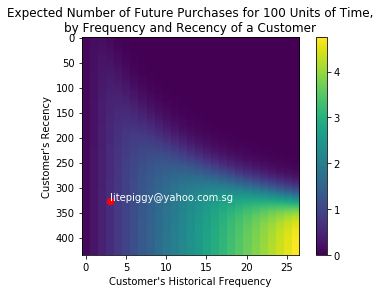

In [36]:
# This Recency-Frequency plot maps a customer's expected purchases by the next year

from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf, T=100)

test_email = 'litepiggy@yahoo.com.sg'

plt.scatter(x=summary.loc[test_email]['frequency'], y=summary.loc[test_email]['recency'], c='r', s=40)
plt.annotate(test_email, 
             xy = (summary.loc[test_email]['frequency'], summary.loc[test_email]['recency']),
            color = 'white')
# plt.savefig('CLTV.png')
plt.show()



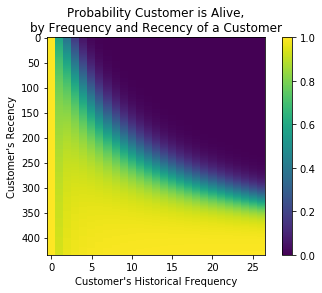

In [37]:
# This maps the probability that they're alive given his or her frequency/recency. 

from lifetimes.plotting import plot_probability_alive_matrix
plt.title("Probability a customer is still alive")
plot_probability_alive_matrix(bgf)
# plt.savefig('Probability a customer is still alive.png')
plt.show()

Customers with high frequency and recency are expected to purchase more in the future and have a higher chance of being alive.  Customers in the blue zone are also of interest, since they are 50/50 on leaving the company but we can still expect them to purchase about 4-6 times during next year.

In the first chart, we can see that if a customer has bought 20 times from you, and their lastest purchase was when they were 70 days old (given the individual is 70 days old), then **they are your best customer (bottom-right)**. The **coldest customers** are those that in the **top-right corner**: they bought a lot quickly, and we haven't seen them in weeks.

There's also that "tail" around (5,70). That represents the customer who buys infrequently, but we've seen him or her recently, so they *might* buy again - we're not sure if they are dead or just between purchases.

# More Model Fitting
To test how model performs on data not yet seen (think cross-validation in standard machine learning literature). Lifetimes has a function to partition dataset called `calibration_and_holdout_data`. 

`Holdout data` refers to sample of data not used in fitting a model; this lets us  test how our model performs on data not yet seen (i.e. cross-validation in standard machine learning literature).

In [38]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transactions= transaction_data, 
                                                   customer_id_col = 'Email', 
                                                   datetime_col= 'Paid at',
                                                   calibration_period_end= "2017-12-31",
                                                   monetary_value_col = 'Subtotal'
                                                   # calibration_period_end= pd.to_datetime('2016-01-01',  format='%Y-%m-%d', errors='ignore') 
                                                  )   

In the following **calibration vs holdout purchases plot**, data is separated into both an in-sample (calibration) and validation (holdout) period.  

The sample period consists from the beginning to 1 June 2017; the validation period spans the rest of the 2017-2018 year. 

The plot groups all customers in the calibration period by their number of repeat purchases (x-axis) and then averages over their repeat purchases in the holdout period (y-axis).  

The orange and blue line presents the model prediction and actual result of the y-axis respectively.  

As we can see, up to until five repeat purchases, the model is able to fairly accurately predict the customer base's behavior out of sample.  After 5, the model does produce a lot more error and over-estimates the average repeat purchases.  This is due to the lack of data for those large repeat purchasing customers.

In [39]:
summary_cal_holdout.sort_values(by='frequency_cal', ascending=False)

# frequency_cal refers the count of time periods the customer had a purchase in. 
    # So if using days as units, then it’s the count of days the customer had a purchase on.
# T_cal refers to the number of days between calibration_period_end and the customer's first day of purchase
# recency_cal represents the age of the customer when they made their most recent purchases within calibration_period_end date. 
    # recency_cal is equal to the duration between a customer’s first purchase and their latest purchase within calibration_period_end date. 
    # (i.e. if they have made only 1 purchase, the recency is 0.)
    
# But how are freq_holdout, monetary_value_holdout, duration_holdout calculated?

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
Email,,,,,,,
aliceklk@gmail.com,25.0,336.0,387.0,60.640000,1.0,113.0,39
rogini611@gmail.com,20.0,383.0,394.0,192.825000,1.0,110.0,39
charissa_chang@hotmail.com,20.0,346.0,370.0,76.500000,1.0,48.0,39
juhinggeklynn@gmail.com,20.0,248.0,264.0,162.175000,2.0,186.5,39
lavie_ind@yahoo.com,18.0,348.0,385.0,253.722222,2.0,14.0,39
eileenong35@hotmail.com,18.0,386.0,387.0,180.419444,0.0,0.0,39
gemma.l.kyle@gmail.com,17.0,344.0,367.0,96.529412,2.0,277.0,39
yashoda_20@hotmail.com,17.0,360.0,372.0,235.529412,2.0,272.0,39
bgchua2857@hotmail.com,15.0,342.0,345.0,280.766667,1.0,106.0,39


    # This is to verify the dataframe proudced by summary_cal_holdout
sales_data_lifetimes_layout[sales_data_lifetimes_layout['Email'] == 'juhinggeklynn@gmail.com']

The method `plot_calibration_purchases_vs_holdout_purchases` performs fitting on the `_cal` columns, and test on the `_holdout` columns:

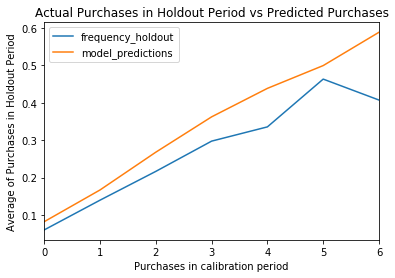

In [40]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

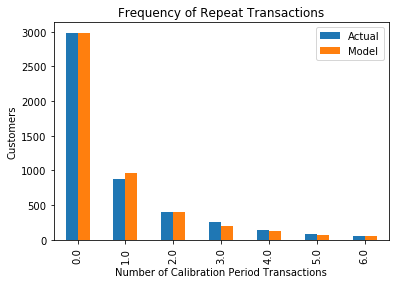

In [41]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

# Estimating customer lifetime value using the Gamma-Gamma model
So far, 
1. the economic value of each transaction have not been taken into account. 
2. We focused mainly on transactions’ occurrences. 

Gamma-Gamma makes a few assumptions: 

1. At the customer level, the transaction/order value varies randomly around each customer’s average transaction value. (That, in itself, isn’t too controversial.) 

2. The observed mean value is an imperfect metric of the latent mean transaction value E(M), where M represents the monetary value. 

3. Average transaction value varies across customers, though these values are stationary. (This is a big assumption to make.)

4. The distribution of average values across customers is independent of the transaction process. In other words, monetary value can be modeled separately from the purchase count and lifetime components of the model. This may or may not hold in typical business situations.

### Training a simple Gamma-Gamma model on the monetary value 

The next steps is to look at the monetary value model. This model follows closely the Gamma-Gamma model discussed in Fader et al. (2004). Note that **the monetary value component is generally very difficult to model. Many factors can affect the price of items in ways that are not accounted for by the model. Long term changes in prices over several years (akin to inflation), discounts, promotions, etc. are difficult to capture in this and other simple monetary value models.** That is something to keep in mind when doing comparisons over the holdout period and making predictions for future purchases. 

In the gamma model, the observed average order value $m_x$ in the training period is an imperfect metric of the latent mean transaction value $E(M)$ at the customer level. 

**The main assumption behind the gamma model is that the average order value at the customer level is distributed according to a gamma distribution of shape $p$ and scale $\nu$ **
$$ p(m_x~|~p, \nu, x) = \frac{(\nu x)^{px}m_x^{px-1}e^{-\nu x m_x}}{\Gamma(px)}$$

where 
* $x$ is the total number of transactions (`rfm['frequency']+1`) 
* $m_x$ is the average order value
* $p$ is the shape of the gamma distribution. The model assumes that this parameter is the same for all customers. 
* $\nu$ is the scale parameter. $\nu$ varies across customers and has a prior that is also gamma distributed with parameters $(q,\gamma)$

The expectation value of the gamma distribution, which is the mean purchase value is $p/\nu$ in this case. The MCMC sampling technique gives us the posterior distribution of $\nu$. To get an estimate of $E(M)$ at the customer level, one simply has to average the value of $p/\nu$ over the MCMC trace values of $\nu$ and $p$, at the customer level. We go over the steps in the cells below. 

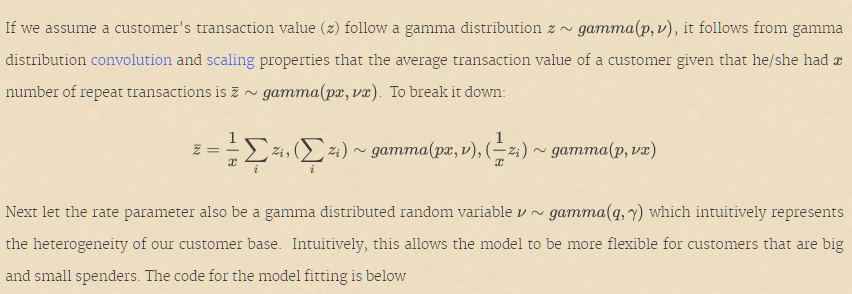

Firstly, we need to create summary data from transactional data also containing economic values for each transaction (i.e. profits or revenues).

In [42]:
summary_with_money_value = summary.copy()
summary_with_money_value

,frequency,recency,T,monetary_value,predicted_purchases
Email,,,,,
001coolgal@gmail.com,3.0,374.0,411.0,81.666667,0.642995
007lavender@gmail.com,0.0,0.0,402.0,0.000000,0.103188
0306isabel@gmail.com,2.0,105.0,225.0,464.000000,0.660910
1060138073@qq.com,0.0,0.0,113.0,0.000000,0.228775
1060138073A@gmail.com,0.0,0.0,113.0,0.000000,0.228775
1070504395@qq.com,1.0,26.0,155.0,90.000000,0.468218
1115006804@qq.com,0.0,0.0,112.0,0.000000,0.229743
1293590203@qq.com,0.0,0.0,237.0,0.000000,0.150268
1404225C@gmail.com,1.0,142.0,226.0,48.000000,0.398935


In [43]:
# from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = summary.copy()
# summary_with_money_value[(summary_with_money_value['monetary_value']== 0)]

returning_customers_summary = summary_with_money_value[(summary_with_money_value['frequency']>0) 
                                                       & (summary_with_money_value['monetary_value']>0)]

returning_customers_summary

,frequency,recency,T,monetary_value,predicted_purchases
Email,,,,,
001coolgal@gmail.com,3.0,374.0,411.0,81.666667,0.642995
0306isabel@gmail.com,2.0,105.0,225.0,464.000000,0.660910
1070504395@qq.com,1.0,26.0,155.0,90.000000,0.468218
1404225C@gmail.com,1.0,142.0,226.0,48.000000,0.398935
1545742698@qq.com,2.0,248.0,414.0,39.500000,0.433940
4n1g3r@gmail.com,1.0,326.0,338.0,96.000000,0.311730
597893321@qq.com,1.0,13.0,29.0,42.000000,0.933632
602596417@qq.com,2.0,52.0,93.0,13.000000,1.106722
609757002@qq.com,1.0,154.0,176.0,132.000000,0.477488


### Gamma-Gamma submodel

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption: **that there is no relationship between the monetary value and the purchase frequency.** 

In practice, we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

More info on the Gamma distribution can be found here
https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Gamma_Distribution_Fitting.pdf

In [44]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.117571
frequency,0.117571,1.000000


The output isn't really close to zero, which means there **_is_** some correlation between monetary value and frequency of purchase. **But we'll proceed anyway**.

At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [45]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
p,q,v = ggf._unload_params('p', 'q', 'v')
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2123 subjects, p: 2.58, q: 7.31, v: 275.12>


In [46]:
# now estimate the average transaction value:
cltv_estimation = pd.DataFrame(ggf.conditional_expected_average_profit(summary_with_money_value['frequency'],
                                              summary_with_money_value['monetary_value'])).reset_index().sort_values(by=0, ascending=False)


In [47]:
print("Expected conditional average profit: %.2f, Population Average profit %.2f, Average profit: %.2f" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    (p*v)/(q-1),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 112.36, Population Average profit 112.38, Average profit: 108.72


Expected conditional average profit calculates what we expect the mean profit to be for our currently observed customers and mixes it with the population average profit which is what the model thinks is to be over the long term for all customers.  This is because there's uncertainty from the amount of orders we have observed from an individual customer (customer frequency).

In [48]:
# Top six customers 

t = 31*3
'''summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                         summary['frequency'], 
                                                                                         summary['recency'], 
                                                                                         summary['T'])'''
best_projected_cust = summary.sort_values('predicted_purchases').tail(8)
# worst_projected_cust = summary.sort_values('predicted_purchases').head(6)
summary.sort_values('predicted_purchases').tail(8)

,frequency,recency,T,monetary_value,predicted_purchases
Email,,,,,
yashoda_20@hotmail.com,19.0,400.0,411.0,239.368421,3.633908
gemma.l.kyle@gmail.com,19.0,401.0,406.0,115.526316,3.672259
lavie_ind@yahoo.com,20.0,404.0,424.0,230.450000,3.721745
rogini611@gmail.com,21.0,410.0,433.0,188.880952,3.836892
charissa_chang@hotmail.com,21.0,372.0,409.0,75.142857,3.979852
casqaureo@gmail.com,7.0,20.0,39.0,103.500000,4.522739
aliceklk@gmail.com,26.0,390.0,426.0,62.653846,4.749313
juhinggeklynn@gmail.com,22.0,296.0,303.0,164.386364,5.257754


The inverse gamma distribution is a two-parameter family of continuous probability distributions on the positive real line, which is the distribution of the reciprocal of a variable distributed according to the gamma distribution. 

The chief use of the inverse gamma distribution is in Bayesian statistics, where the distribution arises as the marginal posterior distribution for the unknown variance of a normal distribution, if an uninformative prior is used, and as an analytically tractable conjugate prior, if an informative prior is required.

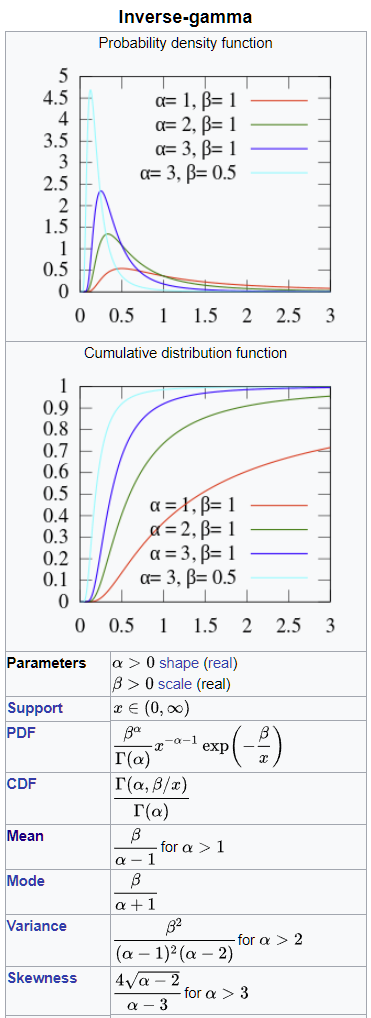

### Plot our top six customer's mean spend/profit distribution below.

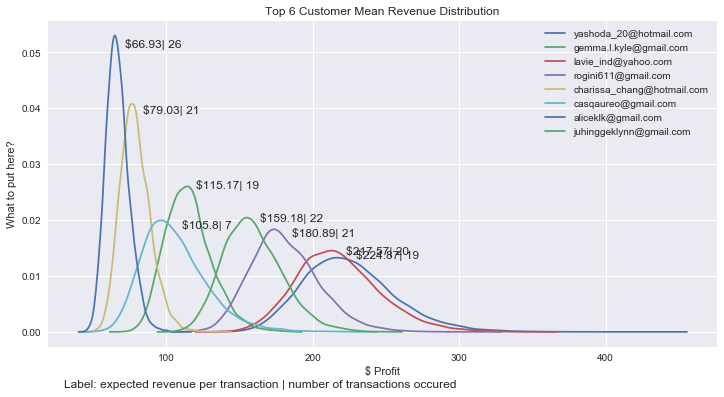

In [49]:
import seaborn as sns
from scipy.stats import invgamma
import matplotlib.pyplot as plt

ret_cust_data = summary[summary['frequency'] > 0] # only look at customers with repeat purchases
customer_scale = p*(v+summary['frequency']*summary['monetary_value'])
customer_shape = p*summary['frequency']+q
ez = customer_scale/(customer_shape-1)

# Plot out the graph
plt.figure(figsize=(12,6))
plt.xlabel('$ Profit')
plt.ylabel('What to put here?')
plt.title('Top 6 Customer Mean Revenue Distribution')
plt.text(x=30 , y= -0.01, s = 'Label: expected revenue per transaction | number of transactions occured')

for ind, i in enumerate(best_projected_cust.index.tolist()):
    ccig = invgamma.rvs(customer_shape[i], scale=customer_scale[i], size = 10000)
    plt.text(ez[i]+5, invgamma.pdf(ez[i], customer_shape[i], scale=customer_scale[i]),
             '$'+str(round(ez[i],2))+'| '+str(int(ret_cust_data.loc[i,'frequency'])))
    sns.distplot(ccig, hist=False, rug=False, label=str(i));
   

Our best customer by far (aliceklk@gmail.com) has an expected revenue of $224.87 per transaction; even though she has 19 repeat transactions, it is rare to see other customers purchase at that range of value. Thus the Gamma-Gamma model emphasizes more uncertainty by fattening the distribution.  

Conversely, customers on the lower end of the spectrum (blue, yellow) tend to bring in less profit per transaction but we find they are easier to predict in terms of their spend behavior (as shown by their peaked distributions).  One can generalize all of this intuitively: as the nominal spending for a customer increases, the distribution shifts outward and the probable range of profit per transaction is driven by:

1. The degree of the shift (higher transaction values lead to more uncertainty)
2. The number of transactions that this customer has had previously (more transactions should lead to more certainty)

## Calculating CLTV
With an expected lifetime of 36 months (3 years)

In [50]:
# for computing the total CLV using the DCF method adjusting for cost of capital:
# https://en.wikipedia.org/wiki/Discounted_cash_flow
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

cltv_table = pd.DataFrame(
    ggf.customer_lifetime_value(
        transaction_prediction_model= bgf, # the model to use to predict the number of future transactions
        frequency= summary_with_money_value['frequency'],
        recency= summary_with_money_value['recency'],
        T= summary_with_money_value['T'],
        monetary_value = summary_with_money_value['monetary_value'],
        time=36, # the lifetime expected for the user in months. Default: 12
        discount_rate=0.01 #  the monthly adjusted discount rate. Default: 0.01
))

In [51]:
cltv_table = cltv_table.sort_values('clv', ascending=False).reset_index()
# cltv_table.to_excel("CLTV_Estimation.xlsx")
cltv_table

,Email,clv
0,sonic0204@hotmail.com,8707.785902
1,juhinggeklynn@gmail.com,7236.262896
2,yashoda_20@hotmail.com,7106.410648
3,lavie_ind@yahoo.com,7046.283959
4,bgchua2857@hotmail.com,6971.827871
5,rogini611@gmail.com,6042.193257
6,tunguyenphuonglan@gmail.com,5364.723145
7,alexis_lwy@yahoo.com,5211.380914
8,eileenong35@hotmail.com,4976.384293
9,choimsik@hotmail.com,4747.839657


In [52]:
summary_with_cltv = cltv_table.merge(summary.reset_index(), how='outer', on='Email')
summary_with_cltv.sort_values('predicted_purchases', ascending = False)

,Email,clv,frequency,recency,T,monetary_value,predicted_purchases
1,juhinggeklynn@gmail.com,7236.262896,22.0,296.0,303.0,164.386364,5.257754
41,aliceklk@gmail.com,2766.738966,26.0,390.0,426.0,62.653846,4.749313
10,casqaureo@gmail.com,4013.912861,7.0,20.0,39.0,103.500000,4.522739
43,charissa_chang@hotmail.com,2735.154247,21.0,372.0,409.0,75.142857,3.979852
5,rogini611@gmail.com,6042.193257,21.0,410.0,433.0,188.880952,3.836892
3,lavie_ind@yahoo.com,7046.283959,20.0,404.0,424.0,230.450000,3.721745
13,gemma.l.kyle@gmail.com,3677.039071,19.0,401.0,406.0,115.526316,3.672259
2,yashoda_20@hotmail.com,7106.410648,19.0,400.0,411.0,239.368421,3.633908
35,phyuwint1231@gmail.com,2845.815085,18.0,388.0,395.0,89.333333,3.556207
56,shufen777@yahoo.com.sg,2455.415069,6.0,59.0,67.0,75.500000,3.379852


### Bringing it all together: 
Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example:

In [53]:
# This shows all the historical transactions of a customer
# jasminet@gmail.com
# choimsik@hotmail.com
# erica.vrt@gmail.com
# lavie_ind@yahoo.com

sales_data_lifetimes_layout[sales_data_lifetimes_layout['Email'] == 'lavie_ind@yahoo.com']

,Paid at,Email,Subtotal
577,2018-01-19 10:24:05,lavie_ind@yahoo.com,8.0
578,2018-01-19 10:23:29,lavie_ind@yahoo.com,3.0
1031,2018-01-02 06:58:25,lavie_ind@yahoo.com,31.0
2119,2017-11-24 08:42:05,lavie_ind@yahoo.com,359.0
2622,2017-11-09 07:51:26,lavie_ind@yahoo.com,104.0
2774,2017-11-03 08:10:12,lavie_ind@yahoo.com,229.0
2878,2017-10-31 08:58:05,lavie_ind@yahoo.com,28.0
2880,2017-10-31 08:57:04,lavie_ind@yahoo.com,164.0
4113,2017-09-20 03:57:34,lavie_ind@yahoo.com,11.0
4114,2017-09-20 03:56:05,lavie_ind@yahoo.com,500.0


In [54]:
# This shows the Gamma-Gamma estimated average transaction value
cltv_estimation[cltv_estimation['Email'] == 'lavie_ind@yahoo.com']

,Email,0
2671,lavie_ind@yahoo.com,217.573175


In [55]:
# Calculated lifetime value
cltv_table[cltv_table['Email'] == 'lavie_ind@yahoo.com']

,Email,clv
3,lavie_ind@yahoo.com,7046.283959


(array([ 736420.,  736542.,  736664.,  736785.,  736907.,  737029.,
         737150.,  737272.,  737394.]), <a list of 9 Text xticklabel objects>)

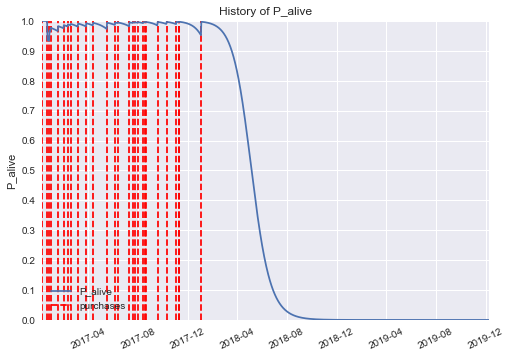

In [61]:
from lifetimes.plotting import plot_history_alive
# phyuwint1231@gmail.com
# jessiejiaqiye@gmail.com
# riasafadhilla@gmail.com
# aliceklk@gmail.com
# jovi.kau@gmail.com
# choimsik@hotmail.com
# erica.vrt@gmail.com
 # 'juhinggeklynn@gmail.com'

id = 'aliceklk@gmail.com'
days_since_birth = 365*3
sp_trans = transaction_data[transaction_data['Email'] == id]
plot_history_alive(model=bgf, 
                   t = days_since_birth, 
                   transactions = sp_trans, 
                   datetime_col = 'Paid at',
                  freq = "D")
plt.xticks(rotation=25)

### Aside: new customers calculation

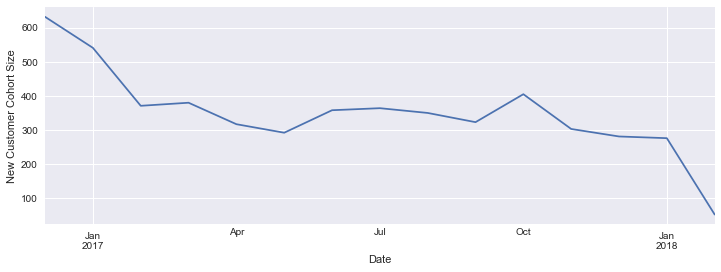

In [57]:
# Keep each email's first transaction record only
unique_cohort = sales_data_lifetimes_layout[['Email', 'Paid at']].sort_values('Paid at').drop_duplicates('Email')

# convert the date of transaction to first day of each month for easy counting
unique_cohort['Date_M'] = unique_cohort['Paid at'].values.astype('datetime64[M]')

# apply grouby function to count the dates
cohort_over_time = unique_cohort[['Date_M', 'Email']].groupby('Date_M').count()
ax = cohort_over_time.plot(legend=False, figsize=(12,4))
ax.set_xlabel('Date'); ax.set_ylabel('New Customer Cohort Size')

# Investigating the heterogenity of both parameters for visualization.

In statistics, homogeneity (and heterogeneity) describes the extent to which a statistical property of any one part of an overall dataset is ASSUMED to be the same as any other parts.

In [ ]:
'''The following code plots the heterogenity of both parameters for visualization.  

(to update)
_As we can see, the death rate centers around the 30%-40% probability but a large portion of customer cohort's still have a high chance of dying after each purchase._ 

The heterogenity of λ is mostly distributed around 0 and 0.02 with a few having a small tail.'''

from scipy.stats import beta
from scipy.stats import gamma
gbd = beta.rvs(bgf.params_['a'], bgf.params_['b'], size = 50000)
ggd = gamma.rvs(bgf.params_['r'], scale=1./bgf.params_['alpha'], size = 50000)
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title('Heterogenity of $p$')
temp = plt.hist(gbd, 20, facecolor='pink', alpha=0.75)
plt.subplot(122)
plt.title('Heterogenity of $\lambda$')
temp = plt.hist(ggd, 20, facecolor='pink', alpha=0.75)